In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from ocroeval.texteval import *
import wids
import Levenshtein as lev

In [10]:
url = "ocr-eval-hocr-reframed-ocr.tar"
results = wids.ShardListDataset([dict(url=url, nsamples=100)])

[{'url': 'ocr-eval-hocr-reframed-ocr.tar', 'nsampl base: None name: None nfiles: 1 nbytes: 0 samples: 100 cache: /tmp/_wids_cache


In [11]:
gt = results[0][".hocr.html"].read().decode("utf-8")
ocr = results[0][".tess.html"].read().decode("utf-8")

In [16]:
gt_boxes, gt_text = extract_bounding_boxes_and_text(gt, element="ocr_line")
ocr_boxes, ocr_text = extract_bounding_boxes_and_text(ocr, element="ocr_line")

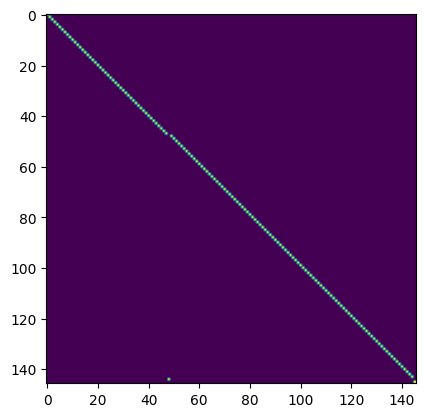

In [19]:
def compute_overlap(gt_box, ocr_box):
    # gt_box and ocr_box are (x0,y0,x1,y1) arrays
    # compute the overlap of the two boxes as area of intersection over minimum area of the two boxes
    # return 0 if there is no overlap
    # return 1 if the boxes are identical
    gt_area = (gt_box[2]-gt_box[0])*(gt_box[3]-gt_box[1])
    ocr_area = (ocr_box[2]-ocr_box[0])*(ocr_box[3]-ocr_box[1])
    intersection_area = max(0, min(gt_box[2], ocr_box[2]) - max(gt_box[0], ocr_box[0])) * max(0, min(gt_box[3], ocr_box[3]) - max(gt_box[1], ocr_box[1]))
    if intersection_area == 0:
        return 0
    else:
        return intersection_area / min(gt_area, ocr_area)

def compute_overlap_matrix(gt_boxes, ocr_boxes):
    overlaps = np.zeros((len(gt_boxes), len(ocr_boxes)))
    for i,gt in enumerate(gt_boxes):
        for j,ocr in enumerate(ocr_boxes):
            overlaps[i,j] = compute_overlap(gt, ocr)
    return overlaps

overlaps = compute_overlap_matrix(gt_boxes, ocr_boxes)
plt.imshow(overlaps)

In [25]:
def compute_match(gt_boxes, ocr_boxes, gt_text, ocr_text):
    overlaps = compute_overlap_matrix(gt_boxes, ocr_boxes)
    best_match_for_gt = np.argmax(overlaps, axis=1)
    missing_ocr = sum(overlaps.max(axis=0) == 0)
    extra_ocr = sum(overlaps.max(axis=1) == 0)
    errors, total = 0, 0
    for i, j in enumerate(best_match_for_gt):
        gtt = normalize(gt_text[i])
        ocrt = normalize(ocr_text[j])
        error = lev.distance(gtt, ocrt)
        errors += error
        total += len(gtt)
        if error > 0:
            print("GT: ", gtt)
            print("OCR:", ocrt)
            print()
    return errors, total, missing_ocr, extra_ocr

errors, total = compute_match(gt_boxes, ocr_boxes, gt_text, ocr_text)


GT:  tivity is likely to be enhanced as
OCR: tivity 1s likely to be enhanced as

GT:  various purposes
OCR: Various purposes

GT:  and inconsistencies among state
OCR: and inconsistencies among State



In [24]:
errors, total

(3, 4573)